In [ ]:
%pip install gymnasium
%pip install stable_baselines3
%pip install stable_baselines


In [ ]:
%pip install keras
%pip install optuna


In [3]:
%pip install pygments

Note: you may need to restart the kernel to use updated packages.


In [16]:
import gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
from gym_anytrading.envs import StocksEnv
import gym_anytrading
import quantstats as qs
import pandas as pd
import matplotlib.pyplot as plt
import logging
import optuna
import pygments
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter


In [5]:
logger = logging.getLogger('training')
logger.setLevel(logging.INFO)

file_handler = logging.FileHandler('training.log')
formatter = logging.Formatter('%(asctime)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [6]:
import yfinance as yf
vgt_data = yf.download("VGT", start = '2018-01-01', end = '2023-01-01')
schd_data = yf.download("SCHD", start = '2018-01-01', end = '2023-01-01')
voo_data = yf.download('VOO', start = '2018-01-01', end = '2023-01-01')
ivv_data = yf.download('IVV', start = '2018-01-01', end = '2023-01-01')
vti_data = yf.download('VTI', start = '2018-01-01', end = '2023-01-01')
agthx_data = yf.download('AGTHX', start = '2018-01-01', end = '2023-01-01')
vinix_data = yf.download('VINIX', start = '2018-01-01', end = '2023-01-01')
qqq_data = yf.download('QQQ', start = '2018-01-01', end = '2023-01-01')
vug_data = yf.download('VUG', start = '2018-01-01', end = '2023-01-01')
vo_data = yf.download('VO', start = '2018-01-01', end = '2023-01-01')

data = pd.concat([vgt_data, schd_data, voo_data, ivv_data, vti_data, agthx_data, vinix_data, qqq_data, vug_data, vo_data]) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
#Rolling window split. Two year training data

train_df = data[:2*365]
val_df_1 = data[2*365:3*365]
val_df_2 = data[3*365:4*365]
val_df_3 = data[4*365:5*365]

In [13]:
def ModelCreation():

    #Creating Logging env
    logger = logging.getLogger('training')
    logger.setLevel(logging.INFO)

    file_handler = logging.FileHandler('training.log')
    formatter = logging.Formatter('%(asctime)s - %(message)s')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    #Creating training env

    window_size = 10
    start_index = window_size
    end_index = len(data)

    train_env = gym.make(
            'stocks-v0',
            df = train_df,
            window_size = window_size,
            frame_bound = (start_index, end_index)
        )

    val_env1 = gym.make(
        'stocks-v0',
        df = val_df_1,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )




    val_env2 = gym.make(
        'stocks-v0',
        df = val_df_2,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )



    val_env3 = gym.make(
        'stocks-v0',
        df = val_df_3,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )

    env1 = DummyVecEnv([lambda : train_env, lambda : val_env1, lambda : val_env2, lambda : val_env3])

    #Setting up hyperparameter tuners

    def optimizePPO(trial):
        return {
            'n_steps' : int(trial.suggest_loguniform('n_steps', 16, 2048)),
            'gamma' : trial.suggest_loguniform('gamma', 0.9, 0.9999),
            'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-5, 1.),
            'ent_coef' : trial.suggest_loguniform('ent_coef', 1e-8, 1e-1),
            'clip_range': trial.suggest_uniform('clip_range', 0.1, 0.4),
            'n_epochs' : int(trial.suggest_loguniform('n_epochs', 1, 48)),
            'gae_lambda': trial.suggest_uniform('gae_lambda', 0.8, 1.)
        }

    def OptimizeA2C(trial):

        return {
            'n_steps': trial.suggest_int('n_steps', 16, 2048),
            'gamma': trial.suggest_uniform('gamma', 0.9, 0.9999),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1.),
            'ent_coef': trial.suggest_loguniform('ent_coef', 1e-8, 1e-1),
            'vf_coef': trial.suggest_loguniform('vf_coef', 0.5, 1.) 
        }

    file_handler.close()
    logger.removeHandler(file_handler)

    file_handler = logging.FileHandler('training.log')
    logger.addHandler(file_handler)


    logger.info('Starting Hyperparameter Tuning...')

    
    def Optimize_PPO_agent(trial):
        model_params = optimizePPO(trial)
        env = env1
        model = PPO('MlpPolicy', train_env, verbose=1, **model_params)
        model.learn(10000)

        rewards = []
        global n_steps
        n_steps = 0

        n_episodes, reward_sum = 0, 0.0

        obs = env.reset()
        while n_episodes < 4:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            reward_sum += reward

            if done.all():
                rewards.append(reward_sum)
                reward_sum = 0.0
                n_episodes += 1
                obs = env.reset()

        last_reward = np.mean(rewards)
        trial.report(-1 * last_reward, step = n_steps)

        return -1 * last_reward

    def Optimize_A2C_agent(trial):
        model_params = OptimizeA2C(trial)
        env = env1
        model = A2C('MlpPolicy', train_env, verbose=1, **model_params)
        model.learn(10000)

        rewards = []
        global n_steps
        n_steps = 0

        n_episodes, reward_sum = 0, 0.0

        obs = env.reset()
        while n_episodes < 4:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            reward_sum += reward

            if done.all():
                rewards.append(reward_sum)
                reward_sum = 0.0
                n_episodes += 1
                obs = env.reset()

        last_reward = np.mean(rewards)
        trial.report(-1 * last_reward, step = n_steps)

        return -1 * last_reward


    ppo_study = optuna.create_study()
    ppo_study.optimize(Optimize_PPO_agent, n_trials = 3)

    a2c_study = optuna.create_study()
    a2c_study.optimize(Optimize_A2C_agent, n_trials = 3)

    ppo_best_params = ppo_study.best_params
    ppo_best_params['clip_range'] = float(ppo_best_params['clip_range'])
    ppo_best_params['n_steps'] = int(ppo_best_params['n_steps'])
    ppo_best_params['n_epochs'] = int(ppo_best_params['n_epochs'])
    
    a2c_best_params = a2c_study.best_params

    logger.info(f'Hyperparameter tuning is complete. The A2C best parameters are: {a2c_best_params} and the best PPO parameters are: {ppo_best_params}')

    logger.info('Initializing the PPO and A2C models...')
    ppo_agent = PPO('MlpPolicy', train_env, verbose=1, **ppo_best_params)
    a2c_agent = A2C('MlpPolicy', train_env, verbose=1, **a2c_best_params)

    logger.info('Training the PPO Agent...')
    ppo_agent.learn(total_timesteps=10000)

    logger.info('Training the A2C Agent...')
    a2c_agent.learn(total_timesteps=10000)

    logger.info('Training is complete')


    envs = [val_env1, val_env2, val_env3]

    def evalModel():

        num_years = 3
        counter = 3

        while counter <= num_years:

            for i in envs:
                ppo_rewards = []
                obs1 = i.reset()

                while True:
                    action, _ = ppo_agent.predict(obs1)
                    logger.info(f'PPO Took action {action} in state {obs1}')
                    obs, reward, done, info = i.step(action)
                    ppo_rewards.append(reward)

                    if done:
                        break

                print(f'PPO average validation for year {counter} reward: ', np.mean(ppo_rewards))


                a2c_rewards = []
                obs2 = val_env1.reset()

                while True:
                    action, _ = a2c_agent.predict(obs2)
                    obs, reward, done, info = val_env1.step(action)
                    a2c_rewards.append(reward)

                    if done:
                        break

                print(f'A2C average validation for year {counter} reward: ', np.mean(a2c_rewards))

                if np.mean(ppo_rewards) > np.mean(a2c_rewards):
                    agent = ppo_agent
                    action, _ = agent.predict(obs1)
                    print(f'Agent chosen for year {counter} is PPO')
                else:
                    agent = a2c_agent
                    action, _ = agent.predict(obs2)
                    print(f'Agent chosen for year {counter} is A2C')

                counter += 1

                plt.figure(figsize = (16,6))
                i.render_all()
                plt.show()

        print("info:", info)
        plt.plot(ppo_rewards, label = 'PPO')
        plt.plot(a2c_rewards, label = 'A2C')

        plt.legend()
        plt.title('Agent Rewards')
        plt.show()



    evalModel()


    




C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 2)
  logger.warn(
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
[I 2023-08-07 15:53:17,915] A new study created in memory with name: no-name-aa910e85-465b-4e70-9ff8-

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 719      |
|    ep_rew_mean     | -6.04    |
| time/              |          |
|    fps             | 1871     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 858      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 719         |
|    ep_rew_mean          | 6.41        |
| time/                   |             |
|    fps                  | 694         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 1716        |
| train/                  |             |
|    approx_kl            | 0.022355732 |
|    clip_fraction        | 0           |
|    clip_range           | 0.258       |
|    entropy_loss   

[I 2023-08-07 16:00:43,407] Trial 0 finished with value: 23400.41796875 and parameters: {'n_steps': 858.5361381169714, 'gamma': 0.9490478434393127, 'learning_rate': 4.0086912700318435e-05, 'ent_coef': 1.7890394317526314e-05, 'clip_range': 0.25814926927621584, 'n_epochs': 36.45081120584223, 'gae_lambda': 0.8922203519888323}. Best is trial 0 with value: 23400.41796875.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1956 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 80   |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 876           |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 160           |
| train/                  |               |
|    approx_kl            | 2.7553644e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.296         |
|    entropy_loss         | -0.693        |
|    explained_variance   | -0.00103      |
|    learning_rate        | 0.000111      |
|    loss                 | 8.06          |
|    n_updates            | 17            |
|    policy_gradient_loss | 0.000262

C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 80`, after every 1 untruncated mini-batches, there will be a truncated mini-batch of size 16
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=80 and n_envs=1)
  warnings.warn(


------------------------------------------
| time/                   |              |
|    fps                  | 749          |
|    iterations           | 3            |
|    time_elapsed         | 0            |
|    total_timesteps      | 240          |
| train/                  |              |
|    approx_kl            | 0.0024202392 |
|    clip_fraction        | 0            |
|    clip_range           | 0.296        |
|    entropy_loss         | -0.693       |
|    explained_variance   | 0.00715      |
|    learning_rate        | 0.000111     |
|    loss                 | 1.01         |
|    n_updates            | 34           |
|    policy_gradient_loss | -0.00175     |
|    value_loss           | 1.92         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 700          |
|    iterations           | 4            |
|    time_elapsed         | 0            |
|    total_

[I 2023-08-07 16:08:01,815] Trial 1 finished with value: 24685.0546875 and parameters: {'n_steps': 80.59520038055851, 'gamma': 0.9903188912608643, 'learning_rate': 0.00011103574884641552, 'ent_coef': 4.219585366922932e-06, 'clip_range': 0.2961256451714352, 'n_epochs': 17.82826224708506, 'gae_lambda': 0.842046396822605}. Best is trial 0 with value: 23400.41796875.
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1996`, after every 31 untruncated mini-batches, there will be a truncated mini-batch of size 12
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1996 and n_envs=1)
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 719      |
|    ep_rew_mean     | 75.7     |
| time/              |          |
|    fps             | 2135     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1996     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 719         |
|    ep_rew_mean          | 24.3        |
| time/                   |             |
|    fps                  | 1854        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 3992        |
| train/                  |             |
|    approx_kl            | 0.004183104 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.143       |
|    entropy_loss   

[I 2023-08-07 16:15:24,016] Trial 2 finished with value: 17539.615234375 and parameters: {'n_steps': 1996.518991101541, 'gamma': 0.9799470564948094, 'learning_rate': 0.00573620355265577, 'ent_coef': 0.0002001644538207146, 'clip_range': 0.1431103328367742, 'n_epochs': 3.863351219325466, 'gae_lambda': 0.8069854407520837}. Best is trial 2 with value: 17539.615234375.
[I 2023-08-07 16:15:24,017] A new study created in memory with name: no-name-e77a72e8-a9f1-4ab5-b459-86a76a548504
C:\Users\12016\AppData\Local\Temp\ipykernel_18764\1647697344.py:70: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'gamma': trial.suggest_uniform('gamma', 0.9, 0.9999),
C:\Users\12016\AppData\Local\Temp\ipykernel_18764\1647697344.py:71: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


[I 2023-08-07 16:22:39,923] Trial 0 finished with value: 17145.97265625 and parameters: {'n_steps': 1492, 'gamma': 0.9617955195100133, 'learning_rate': 2.834930153579846e-05, 'ent_coef': 0.014815099907219803, 'vf_coef': 0.5037490579777371}. Best is trial 0 with value: 17145.97265625.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


[I 2023-08-07 16:29:45,605] Trial 1 finished with value: 22345.70703125 and parameters: {'n_steps': 1203, 'gamma': 0.9829546621954943, 'learning_rate': 0.000977067043911999, 'ent_coef': 0.002154305399097091, 'vf_coef': 0.6480447379308096}. Best is trial 0 with value: 17145.97265625.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


[I 2023-08-07 16:36:53,593] Trial 2 finished with value: 16804.28125 and parameters: {'n_steps': 1355, 'gamma': 0.9859856054212344, 'learning_rate': 2.3980891722023547e-05, 'ent_coef': 0.00045830152398968854, 'vf_coef': 0.5874314273872153}. Best is trial 2 with value: 16804.28125.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 719      |
|    ep_rew_mean     | 22.5     |
| time/              |          |
|    fps             | 2020     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1996     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 719          |
|    ep_rew_mean          | 77           |
| time/                   |              |
|    fps                  | 1804         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 3992         |
| train/                  |              |
|    approx_kl            | 0.0072106123 |

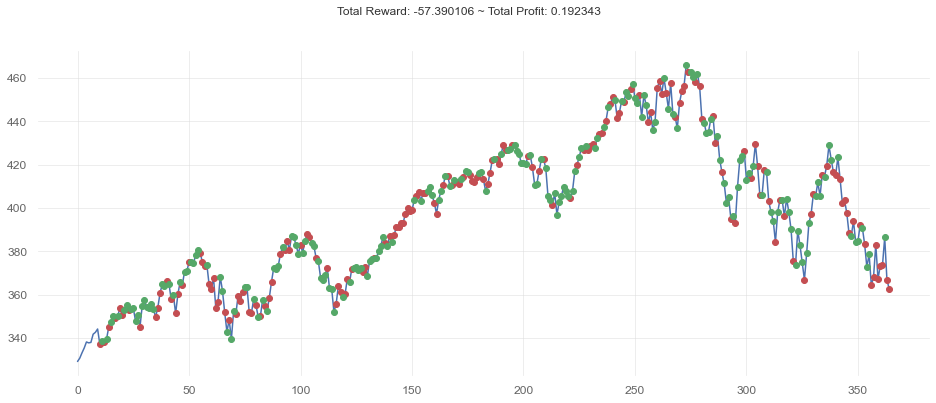

PPO average validation for year 4 reward:  -0.6946606393587791
A2C average validation for year 4 reward:  0.07601730432887535
Agent chosen for year 4 is A2C


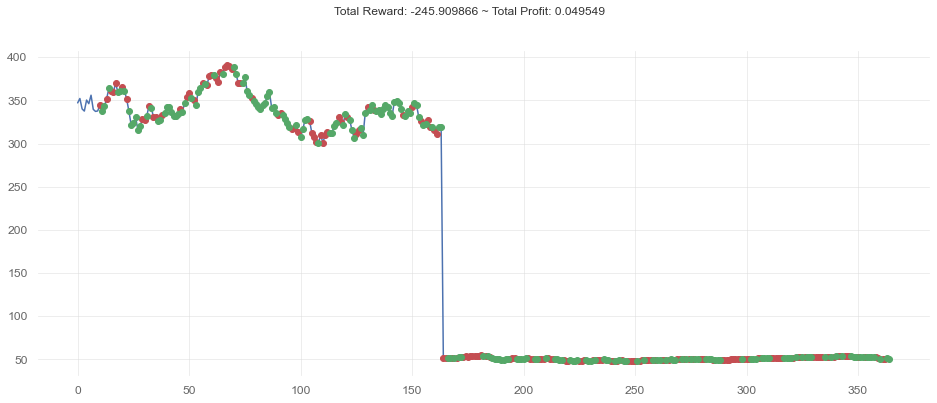

PPO average validation for year 5 reward:  -0.021977473113496425
A2C average validation for year 5 reward:  0.02556433381333863
Agent chosen for year 5 is A2C


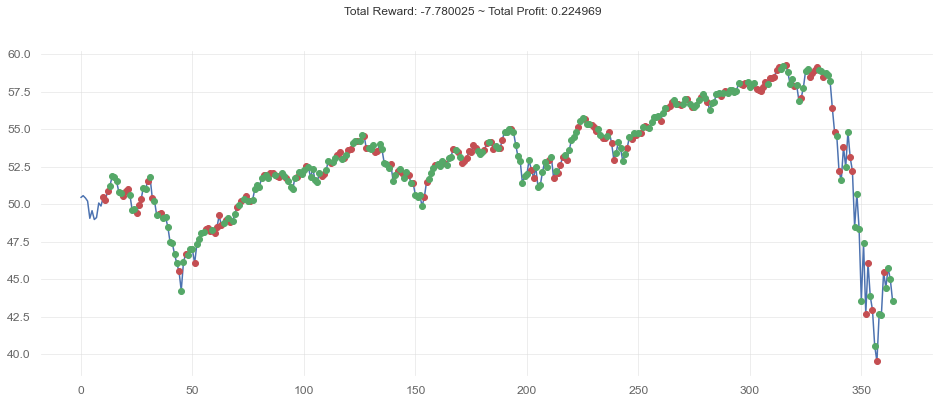

info: {'total_reward': 9.049774169921875, 'total_profit': 0.2645781559764063, 'position': 1}


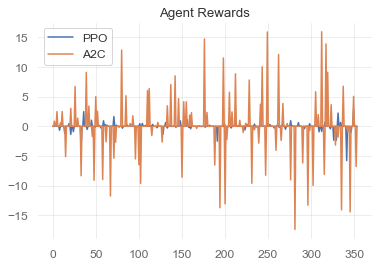

In [14]:
ModelCreation()

In [18]:
model_html = pygments.highlight(model_startup, PythonLexer(), HtmlFormatter())

In [19]:
with open('model.html', 'w') as f:
    f.write(model_html)